In [4]:
import os

import numpy as np
import pandas as pd
import featuretools as ft

from glob import glob

from dask import bag
from dask.diagnostics import ProgressBar
from featuretools.primitives import *

In [5]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}
to_read = ['app', 'device', 'os', 'channel', 'is_attributed', 'click_time']
to_parse = ['click_time']

In [6]:
pbar = ProgressBar()
pbar.register()

In [7]:
input_path = '../data/interim/partitioned/channel'
filenames = glob(f"{input_path}/train_*.csv")

In [9]:
def createEntitySet(filename):
    df = pd.read_csv(filename, usecols=to_read, dtype=dtypes, parse_dates=to_parse)
    df['id'] = range(len(df))
    
    es = ft.EntitySet(id='clicks')
    es = es.entity_from_dataframe(
        entity_id='clicks',
        dataframe=df,
        index='id',
        time_index='click_time',
        
        variable_types={
            'app': ft.variable_types.Categorical,
            'device': ft.variable_types.Categorical,
            'os': ft.variable_types.Categorical,
            'channel': ft.variable_types.Categorical,
            'is_attributed': ft.variable_types.Boolean,
        }
    )

    es = es.normalize_entity(base_entity_id='clicks', new_entity_id='channels', index='channel', make_time_index=False)
    es.add_last_time_indexes()
    return es


def calc_feature_matrix(es, entity_id, cutoff_time):
    feature_matrix, _ = ft.dfs(
        entityset=es,
        target_entity=entity_id,
        cutoff_time=cutoff_time,
        training_window=ft.Timedelta("1 hours"),
        max_depth=1
    )

    return feature_matrix

def createFeatures(filename, entity_sets):
    df_train = pd.read_csv(filename, usecols=to_read, dtype=dtypes, parse_dates=to_parse)    
    cutoff_time = df_train['click_time'].min()
    feature_matrices = entity_sets.map(calc_feature_matrix, entity_id='channels', cutoff_time=cutoff_time)
    out = feature_matrices.compute()
    feature_matrix = pd.concat(out)
    df_train_features = df_train.join(feature_matrix, on='channel')
    name, ext = os.path.splitext(filename)
    output_file = f"{name}_channel_features{ext}"
    df_train_features.to_csv(output_file, index=False)

In [10]:
b = bag.from_sequence(filenames)
entity_sets = b.map(createEntitySet)

In [13]:
filenames_train = glob('../data/interim/train_2017-*00.csv')
b_train = bag.from_sequence(filenames_train)
features_train = b_train.map(createFeatures, entity_sets)
features_train.compute()

In [55]:
glob('../data/interim/train_2017-*_features.csv')

['../data/interim/train_2017-11-08_0200.csv',
 '../data/interim/train_2017-11-07_0900.csv',
 '../data/interim/train_2017-11-07_2200.csv',
 '../data/interim/train_2017-11-07_1200.csv',
 '../data/interim/train_2017-11-08_2100.csv',
 '../data/interim/train_2017-11-08_1000.csv',
 '../data/interim/train_2017-11-06_2100.csv',
 '../data/interim/train_2017-11-06_1700.csv',
 '../data/interim/train_2017-11-09_0300.csv',
 '../data/interim/train_2017-11-07_1100.csv',
 '../data/interim/train_2017-11-07_2000.csv',
 '../data/interim/train_2017-11-08_0700.csv',
 '../data/interim/train_2017-11-08_0400.csv',
 '../data/interim/train_2017-11-09_0600.csv',
 '../data/interim/train_2017-11-08_0100.csv',
 '../data/interim/train_2017-11-07_1600.csv',
 '../data/interim/train_2017-11-09_0900.csv',
 '../data/interim/train_2017-11-07_1700.csv',
 '../data/interim/train_2017-11-09_0500.csv',
 '../data/interim/train_2017-11-08_2000.csv',
 '../data/interim/train_2017-11-07_0700.csv',
 '../data/interim/train_2017-11-08

In [14]:
import xgboost as xgb

In [15]:
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=4, reg_lambda=1, scale_pos_weight=9, seed=None,
       silent=True, subsample=0.8)

In [16]:
from sklearn import preprocessing

importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

importance_df['mean'] = importance_df.mean(axis=1)

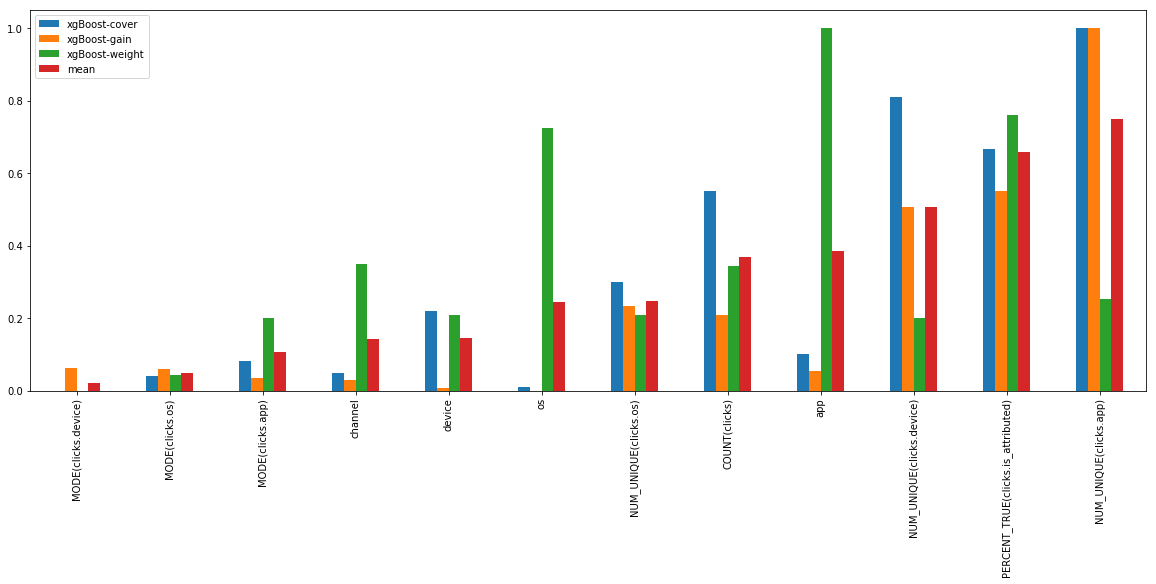

In [17]:
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))